In [2]:
# import rasterio

# # Open the images
# with rasterio.open("g:\\Yehmh\\BCI\\BCI_50ha_2020_08_01_global.tif") as src_image:
#     large_image = src_image.read()
#     large_profile = src_image.profile
#     transform = src_image.transform

# with rasterio.open("g:\\Yehmh\\BCI\\BCI_50ha_2020_08_01_crown.tif") as src_mask:
#     small_mask = src_mask.read()
#     small_profile = src_mask.profile
#     mask_transform = src_mask.transform

# # Get the UTM coordinates of the top-left corner of the mask
# utm_x_min, utm_y_max = mask_transform * (0, 0)

# # Convert UTM coordinates to pixel coordinates in the image
# x_min, y_max = src_image.index(utm_x_min, utm_y_max)

# # Determine the dimensions of the mask image
# mask_height, mask_width = small_mask.shape[1:]

# # Update the transformation matrix of the larger image
# new_transform = rasterio.transform.Affine(transform.a, transform.b, utm_x_min, 
#                                           transform.d, transform.e, utm_y_max)

# # Update the profile of the larger image to match the mask
# large_profile['transform'] = new_transform
# large_profile['width'] = mask_width
# large_profile['height'] = mask_height

# # Crop the larger image based on the dimensions of the mask
# cropped_image = large_image[:, x_min:x_min + mask_height, y_max:y_max + mask_width]

# # Write the cropped image to a new file
# with rasterio.open("g:\\Yehmh\\BCI\\BCI_50ha_2020_08_01_cropped.tif", 'w', **large_profile) as dst:
#     dst.write(cropped_image)

# print("Cropped image shape:", cropped_image.shape)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

large_image = tifffile.imread("h:\\Yehmh\\BCI\\BCI_50ha_2020_08_01_Clip.tif")
large_mask = tifffile.imread("h:\Yehmh\BCI\BCI_50ha_2020_08_01_crown.tif")

print(large_image.shape)
print(large_mask.shape)

(12320, 22961, 4)
(12320, 22961)


In [4]:
#Desired patch size for smaller images and step size.
patch_size = 256
step = 256

all_img_patches = []
patches_img = patchify(large_image, (patch_size, patch_size, 4), step=step)  #Step=256 for 256 patches means no overlap
print(patches_img.shape)
patches_img = np.squeeze(patches_img)
print(patches_img.shape)
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        single_patch_img = patches_img[i,j,:,:,:3]
        all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap
print(patches_mask.shape)
for i in range(patches_mask.shape[0]):
    for j in range(patches_mask.shape[1]):
        single_patch_mask = patches_mask[i,j,:,:]
        single_patch_mask[single_patch_mask != 0] = 1
        # print(np.max(single_patch_mask))
        all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

print(images.shape)
print(masks.shape)

(48, 89, 1, 256, 256, 4)
(48, 89, 256, 256, 4)
(48, 89, 256, 256)
(4272, 256, 256, 3)
(4272, 256, 256)


In [5]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (3838, 256, 256, 3)
Mask shape: (3838, 256, 256)


In [6]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)
print(dataset)

Dataset({
    features: ['image', 'label'],
    num_rows: 3838
})


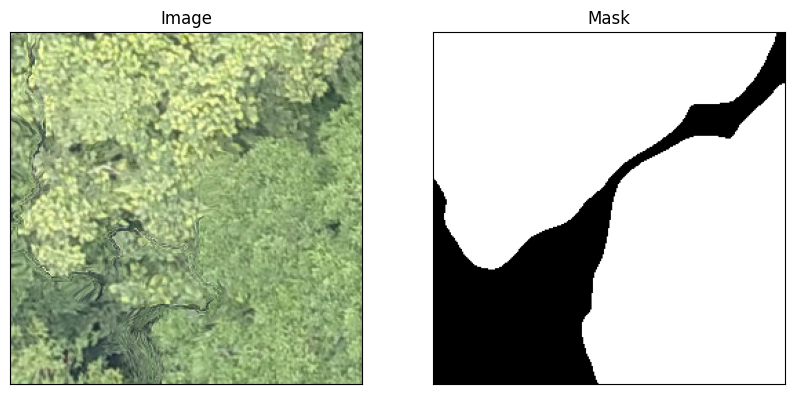

In [7]:
# Let us make sure out images and masks (labels) are loading appropriately

img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image))  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [8]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [9]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [10]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

c:\Users\user\.conda\envs\RS\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
print(type(train_dataset))

example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

<class '__main__.SAMDataset'>
pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [55]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=False)

In [56]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])
ground_truth_mask torch.Size([1, 256, 256])


In [57]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

c:\Users\user\.conda\envs\RS\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [58]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [65]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 100

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = 'cuda'
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  0%|          | 0/3838 [00:00<?, ?it/s]

100%|██████████| 3838/3838 [31:52<00:00,  2.01it/s]


EPOCH: 0
Mean loss: 0.41544400048525904


100%|██████████| 3838/3838 [31:24<00:00,  2.04it/s]


EPOCH: 1
Mean loss: 0.407975796774063


100%|██████████| 3838/3838 [31:40<00:00,  2.02it/s]


EPOCH: 2
Mean loss: 0.39869860150834807


100%|██████████| 3838/3838 [31:27<00:00,  2.03it/s]


EPOCH: 3
Mean loss: 0.3933760525457684


100%|██████████| 3838/3838 [31:36<00:00,  2.02it/s]


EPOCH: 4
Mean loss: 0.3833882197466038


100%|██████████| 3838/3838 [31:33<00:00,  2.03it/s]


EPOCH: 5
Mean loss: 0.37739732058600445


100%|██████████| 3838/3838 [31:30<00:00,  2.03it/s]


EPOCH: 6
Mean loss: 0.37036573521771443


100%|██████████| 3838/3838 [31:27<00:00,  2.03it/s]


EPOCH: 7
Mean loss: 0.36262130383618074


100%|██████████| 3838/3838 [31:56<00:00,  2.00it/s]


EPOCH: 8
Mean loss: 0.35662450160505565


100%|██████████| 3838/3838 [31:37<00:00,  2.02it/s]


EPOCH: 9
Mean loss: 0.34737783412839074


100%|██████████| 3838/3838 [31:37<00:00,  2.02it/s]


EPOCH: 10
Mean loss: 0.3410475262005594


100%|██████████| 3838/3838 [31:38<00:00,  2.02it/s]


EPOCH: 11
Mean loss: 0.3350334420144789


100%|██████████| 3838/3838 [31:42<00:00,  2.02it/s]


EPOCH: 12
Mean loss: 0.33113362975233845


100%|██████████| 3838/3838 [31:33<00:00,  2.03it/s]


EPOCH: 13
Mean loss: 0.3244013347811735


100%|██████████| 3838/3838 [32:20<00:00,  1.98it/s]


EPOCH: 14
Mean loss: 0.31855264356341156


100%|██████████| 3838/3838 [31:57<00:00,  2.00it/s]


EPOCH: 15
Mean loss: 0.31163749042180755


100%|██████████| 3838/3838 [32:28<00:00,  1.97it/s]


EPOCH: 16
Mean loss: 0.3049808393037397


100%|██████████| 3838/3838 [31:49<00:00,  2.01it/s]


EPOCH: 17
Mean loss: 0.29945056473936943


100%|██████████| 3838/3838 [31:35<00:00,  2.03it/s]


EPOCH: 18
Mean loss: 0.294579760298899


100%|██████████| 3838/3838 [31:49<00:00,  2.01it/s]


EPOCH: 19
Mean loss: 0.29135170202278116


100%|██████████| 3838/3838 [32:01<00:00,  2.00it/s]


EPOCH: 20
Mean loss: 0.28515678745212597


100%|██████████| 3838/3838 [31:41<00:00,  2.02it/s]


EPOCH: 21
Mean loss: 0.2855833124079194


100%|██████████| 3838/3838 [32:18<00:00,  1.98it/s]


EPOCH: 22
Mean loss: 0.2758327761915592


100%|██████████| 3838/3838 [47:20<00:00,  1.35it/s]  


EPOCH: 23
Mean loss: 0.2715632426078381


100%|██████████| 3838/3838 [42:40<00:00,  1.50it/s]


EPOCH: 24
Mean loss: 0.2665107944314349


100%|██████████| 3838/3838 [34:55<00:00,  1.83it/s]


EPOCH: 25
Mean loss: 0.2630337909178688


100%|██████████| 3838/3838 [31:02<00:00,  2.06it/s]


EPOCH: 26
Mean loss: 0.25960805099887313


100%|██████████| 3838/3838 [31:05<00:00,  2.06it/s]


EPOCH: 27
Mean loss: 0.2592375190718254


100%|██████████| 3838/3838 [31:18<00:00,  2.04it/s]


EPOCH: 28
Mean loss: 0.25286406065557754


100%|██████████| 3838/3838 [31:09<00:00,  2.05it/s]


EPOCH: 29
Mean loss: 0.24735979531783236


100%|██████████| 3838/3838 [31:00<00:00,  2.06it/s]


EPOCH: 30
Mean loss: 0.24546148176956836


100%|██████████| 3838/3838 [31:01<00:00,  2.06it/s]


EPOCH: 31
Mean loss: 0.24239057680563156


100%|██████████| 3838/3838 [31:04<00:00,  2.06it/s]


EPOCH: 32
Mean loss: 0.2384867118612085


100%|██████████| 3838/3838 [31:04<00:00,  2.06it/s]


EPOCH: 33
Mean loss: 0.23449937129178194


100%|██████████| 3838/3838 [31:01<00:00,  2.06it/s]


EPOCH: 34
Mean loss: 0.2303534578220923


100%|██████████| 3838/3838 [31:04<00:00,  2.06it/s]


EPOCH: 35
Mean loss: 0.23056266170810463


100%|██████████| 3838/3838 [30:56<00:00,  2.07it/s]


EPOCH: 36
Mean loss: 0.22538765458974439


100%|██████████| 3838/3838 [31:01<00:00,  2.06it/s]


EPOCH: 37
Mean loss: 0.22497084642326826


100%|██████████| 3838/3838 [30:59<00:00,  2.06it/s]


EPOCH: 38
Mean loss: 0.21892416679951965


100%|██████████| 3838/3838 [30:56<00:00,  2.07it/s]


EPOCH: 39
Mean loss: 0.21540227640597218


100%|██████████| 3838/3838 [30:50<00:00,  2.07it/s]


EPOCH: 40
Mean loss: 0.2136794631667275


100%|██████████| 3838/3838 [30:51<00:00,  2.07it/s]


EPOCH: 41
Mean loss: 0.20937700625497194


100%|██████████| 3838/3838 [30:52<00:00,  2.07it/s]


EPOCH: 42
Mean loss: 0.20713153774849957


100%|██████████| 3838/3838 [30:53<00:00,  2.07it/s]


EPOCH: 43
Mean loss: 0.20501325751716135


100%|██████████| 3838/3838 [30:53<00:00,  2.07it/s]


EPOCH: 44
Mean loss: 0.2050505578346148


100%|██████████| 3838/3838 [30:53<00:00,  2.07it/s]


EPOCH: 45
Mean loss: 0.19993194812711942


100%|██████████| 3838/3838 [30:52<00:00,  2.07it/s]


EPOCH: 46
Mean loss: 0.20038430077552527


100%|██████████| 3838/3838 [30:52<00:00,  2.07it/s]


EPOCH: 47
Mean loss: 0.19627839896542115


100%|██████████| 3838/3838 [30:53<00:00,  2.07it/s]


EPOCH: 48
Mean loss: 0.19268556431832953


100%|██████████| 3838/3838 [30:53<00:00,  2.07it/s]


EPOCH: 49
Mean loss: 0.1924029703083129


100%|██████████| 3838/3838 [30:52<00:00,  2.07it/s]


EPOCH: 50
Mean loss: 0.18947306556709495


100%|██████████| 3838/3838 [30:53<00:00,  2.07it/s]


EPOCH: 51
Mean loss: 0.1877363144237908


100%|██████████| 3838/3838 [30:53<00:00,  2.07it/s]


EPOCH: 52
Mean loss: 0.18646979217174828


100%|██████████| 3838/3838 [30:50<00:00,  2.07it/s]


EPOCH: 53
Mean loss: 0.1841045840810845


100%|██████████| 3838/3838 [30:50<00:00,  2.07it/s]


EPOCH: 54
Mean loss: 0.1834221957145987


100%|██████████| 3838/3838 [30:56<00:00,  2.07it/s]


EPOCH: 55
Mean loss: 0.179635480980757


100%|██████████| 3838/3838 [30:50<00:00,  2.07it/s]


EPOCH: 56
Mean loss: 0.17733512335669074


100%|██████████| 3838/3838 [30:49<00:00,  2.07it/s]


EPOCH: 57
Mean loss: 0.1771956737772094


100%|██████████| 3838/3838 [30:50<00:00,  2.07it/s]


EPOCH: 58
Mean loss: 0.17475599352464233


100%|██████████| 3838/3838 [30:54<00:00,  2.07it/s]


EPOCH: 59
Mean loss: 0.17178382149037003


100%|██████████| 3838/3838 [30:54<00:00,  2.07it/s]


EPOCH: 60
Mean loss: 0.17213717389720865


100%|██████████| 3838/3838 [30:56<00:00,  2.07it/s]


EPOCH: 61
Mean loss: 0.16847623703280662


100%|██████████| 3838/3838 [30:54<00:00,  2.07it/s]


EPOCH: 62
Mean loss: 0.1695179070443409


100%|██████████| 3838/3838 [30:54<00:00,  2.07it/s]


EPOCH: 63
Mean loss: 0.1664026452898672


100%|██████████| 3838/3838 [31:00<00:00,  2.06it/s]


EPOCH: 64
Mean loss: 0.16287830570974712


100%|██████████| 3838/3838 [30:06<00:00,  2.13it/s]


EPOCH: 65
Mean loss: 0.16473308399140854


100%|██████████| 3838/3838 [29:23<00:00,  2.18it/s]


EPOCH: 66
Mean loss: 0.1602449760968258


100%|██████████| 3838/3838 [29:21<00:00,  2.18it/s]


EPOCH: 67
Mean loss: 0.15805294751681487


100%|██████████| 3838/3838 [29:40<00:00,  2.16it/s]


EPOCH: 68
Mean loss: 0.1579955882210064


100%|██████████| 3838/3838 [29:54<00:00,  2.14it/s]


EPOCH: 69
Mean loss: 0.15719827980555512


100%|██████████| 3838/3838 [30:05<00:00,  2.13it/s]


EPOCH: 70
Mean loss: 0.15549739547891095


100%|██████████| 3838/3838 [30:13<00:00,  2.12it/s]


EPOCH: 71
Mean loss: 0.1540547608654328


100%|██████████| 3838/3838 [30:13<00:00,  2.12it/s]


EPOCH: 72
Mean loss: 0.1523977105991976


100%|██████████| 3838/3838 [30:13<00:00,  2.12it/s]


EPOCH: 73
Mean loss: 0.1556279061652952


100%|██████████| 3838/3838 [30:14<00:00,  2.12it/s]


EPOCH: 74
Mean loss: 0.1505701662792506


100%|██████████| 3838/3838 [30:13<00:00,  2.12it/s]


EPOCH: 75
Mean loss: 0.1493212883502696


100%|██████████| 3838/3838 [30:14<00:00,  2.11it/s]


EPOCH: 76
Mean loss: 0.1468591410775841


100%|██████████| 3838/3838 [30:14<00:00,  2.12it/s]


EPOCH: 77
Mean loss: 0.148186462236285


100%|██████████| 3838/3838 [30:17<00:00,  2.11it/s]


EPOCH: 78
Mean loss: 0.14540195059697428


100%|██████████| 3838/3838 [30:14<00:00,  2.12it/s]


EPOCH: 79
Mean loss: 0.14369815387089863


100%|██████████| 3838/3838 [30:14<00:00,  2.12it/s]


EPOCH: 80
Mean loss: 0.14326899620278594


100%|██████████| 3838/3838 [30:22<00:00,  2.11it/s]


EPOCH: 81
Mean loss: 0.14176006141292408


100%|██████████| 3838/3838 [30:23<00:00,  2.10it/s]


EPOCH: 82
Mean loss: 0.14219256090216617


100%|██████████| 3838/3838 [30:22<00:00,  2.11it/s]


EPOCH: 83
Mean loss: 0.13933296484151267


100%|██████████| 3838/3838 [30:18<00:00,  2.11it/s]


EPOCH: 84
Mean loss: 0.13809636995234853


100%|██████████| 3838/3838 [30:19<00:00,  2.11it/s]


EPOCH: 85
Mean loss: 0.1368619073203795


100%|██████████| 3838/3838 [30:13<00:00,  2.12it/s]


EPOCH: 86
Mean loss: 0.13591526972849066


100%|██████████| 3838/3838 [30:14<00:00,  2.12it/s]


EPOCH: 87
Mean loss: 0.1351678972606446


100%|██████████| 3838/3838 [30:14<00:00,  2.12it/s]


EPOCH: 88
Mean loss: 0.13313353052433172


100%|██████████| 3838/3838 [30:14<00:00,  2.12it/s]


EPOCH: 89
Mean loss: 0.1337518546757634


100%|██████████| 3838/3838 [30:13<00:00,  2.12it/s]


EPOCH: 90
Mean loss: 0.13248173113204678


100%|██████████| 3838/3838 [30:14<00:00,  2.11it/s]


EPOCH: 91
Mean loss: 0.13089779004366883


100%|██████████| 3838/3838 [30:16<00:00,  2.11it/s]


EPOCH: 92
Mean loss: 0.13091043251027054


100%|██████████| 3838/3838 [30:15<00:00,  2.11it/s]


EPOCH: 93
Mean loss: 0.1289689991620185


100%|██████████| 3838/3838 [30:14<00:00,  2.12it/s]


EPOCH: 94
Mean loss: 0.1281582614118071


100%|██████████| 3838/3838 [30:13<00:00,  2.12it/s]


EPOCH: 95
Mean loss: 0.12725505305420215


100%|██████████| 3838/3838 [30:18<00:00,  2.11it/s]


EPOCH: 96
Mean loss: 0.12662732269416627


100%|██████████| 3838/3838 [30:15<00:00,  2.11it/s]


EPOCH: 97
Mean loss: 0.12474775906777884


100%|██████████| 3838/3838 [30:13<00:00,  2.12it/s]


EPOCH: 98
Mean loss: 0.12764546885927677


100%|██████████| 3838/3838 [30:14<00:00,  2.12it/s]

EPOCH: 99
Mean loss: 0.12255663990389228


In [60]:
torch.cuda.empty_cache()

In [66]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "h:/Yehmh/_model/0514_fine_tune_sam_epoch100.pth")